## Initial Setup

In [1]:
%%capture
#%%script false
!pip install shap
!pip install xgboost
!pip install catboost
!pip install lightgbm
#!pip install tensorboardcolab
# !pip install scikit-optimize==0.6

#Restart Runtime

## Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('figure', figsize=(20.0, 6.0))

# import shap
# from tqdm import tqdm_notebook as tqdm

#from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import StratifiedShuffleSplit #, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold

import xgboost as xgb
#import lightgbm as lgb
#import catboost as cat

#import sklearn.svm as svm
#import sklearn.neighbors as knn


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import mean_squared_error #, mean_squared_log_error

In [ ]:
np.array([["TN", "FP"],["FN", "TP"]])

array([['TN', 'FP'],
       ['FN', 'TP']], dtype='<U2')

In [3]:
# Change id only
train_data_og = pd.read_csv("https://drive.google.com/uc?export=download&id=1uLYKLv2sW4ivWIu5LWSzc5EDCiQCq6wR")
sub_data_og = pd.read_csv("https://drive.google.com/uc?export=download&id=1pHLevYAF82LDq0TF8F3Uigi7Er5rwuLX")

### Manipulation

Mean Encoding.  
Divide and Multiply columns.  


Time Series  
Date parts  
Lag values  
Difference between dates 

In [19]:
print(train_data_og.shape) ; print(sub_data_og.shape)

(245725, 11)
(105312, 10)


In [17]:
print(train_data_og.isna().sum())
print(sub_data_og.isna().sum())

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64
ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64


In [154]:
train_data = train_data_og.copy()
train_data_og.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [155]:
sub_data = sub_data_og.copy()
sub_data_og.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [27]:
print(np.unique(train_data.Occupation)); print(np.unique(sub_data.Occupation))

['Entrepreneur' 'Other' 'Salaried' 'Self_Employed']
['Entrepreneur' 'Other' 'Salaried' 'Self_Employed']


In [28]:
print(np.unique(train_data.Channel_Code)); print(np.unique(sub_data.Channel_Code))

['X1' 'X2' 'X3' 'X4']
['X1' 'X2' 'X3' 'X4']


In [29]:
print(np.unique(train_data.Gender)); print(np.unique(sub_data.Gender))

['Female' 'Male']
['Female' 'Male']


In [31]:
print(np.unique(train_data.Region_Code)); print(np.unique(sub_data.Region_Code))

['RG250' 'RG251' 'RG252' 'RG253' 'RG254' 'RG255' 'RG256' 'RG257' 'RG258'
 'RG259' 'RG260' 'RG261' 'RG262' 'RG263' 'RG264' 'RG265' 'RG266' 'RG267'
 'RG268' 'RG269' 'RG270' 'RG271' 'RG272' 'RG273' 'RG274' 'RG275' 'RG276'
 'RG277' 'RG278' 'RG279' 'RG280' 'RG281' 'RG282' 'RG283' 'RG284']
['RG250' 'RG251' 'RG252' 'RG253' 'RG254' 'RG255' 'RG256' 'RG257' 'RG258'
 'RG259' 'RG260' 'RG261' 'RG262' 'RG263' 'RG264' 'RG265' 'RG266' 'RG267'
 'RG268' 'RG269' 'RG270' 'RG271' 'RG272' 'RG273' 'RG274' 'RG275' 'RG276'
 'RG277' 'RG278' 'RG279' 'RG280' 'RG281' 'RG282' 'RG283' 'RG284']


In [32]:
print(np.unique(train_data.Is_Active)); print(np.unique(sub_data.Is_Active))

['No' 'Yes']
['No' 'Yes']


In [49]:
print((train_data_og.groupby(["ID"]).size() > 1).sum()) ; print((sub_data_og.groupby(["ID"]).size() > 1).sum())

0
0


In [4]:
def clean_data(dataset) :

    op_set_1 = (dataset
                .assign( log_avg_ac_bal = np.log(dataset.Avg_Account_Balance) ) # use np.where, dataset.replace, dataset.fillna
                .assign(Credit_Product = dataset.Credit_Product.fillna("NA"))
                .assign(Gender = np.where(dataset.Gender == "Male", 1, 0 )) #- mean_enconding
                .assign(Is_Active = np.where(dataset.Is_Active == "Yes", 1, 0 )) #- mean_enconding
                #.query( "colname = value" )
                .drop( ["ID"], axis = 1 )
                )

    return op_set_1

train_data = clean_data(train_data_og)
sub_data = clean_data(sub_data_og)

train_data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,log_avg_ac_bal
0,0,73,RG268,Other,X3,43,No,1045696,0,0,13.860193
1,0,30,RG277,Salaried,X1,32,No,581988,0,0,13.274205
2,0,56,RG268,Self_Employed,X3,26,No,1484315,1,0,14.210464
3,1,34,RG270,Salaried,X1,19,No,470454,0,0,13.061453
4,0,30,RG282,Salaried,X1,33,No,886787,0,0,13.695360


In [175]:
sub_data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Is_Active,log_avg_ac_bal,VinByBal,perAgeBal,LogVinByBal,LogperAgeBal
0,1,29,RG254,Other,X1,25,Yes,0,13.517598,29694.640000,25598.827586,0.540704,0.466124
1,1,43,RG268,Other,X2,49,NA,0,13.738129,18888.510204,21524.116279,0.280370,0.319491
2,1,31,RG270,Salaried,X1,14,No,0,12.282798,15424.928571,6966.096774,0.877343,0.396219
3,1,29,RG272,Other,X1,33,No,0,13.674028,26305.151515,29933.448276,0.414364,0.471518
4,0,29,RG270,Other,X1,19,No,0,13.395572,34583.526316,22658.172414,0.705030,0.461916


Feature Enginerring - divide and multiply (A/B, A/B*C, A+B / C^D, etc)

In [5]:
def feature_eng(dataset) :
    
    op_set_2 = (dataset
                .assign( VinByBal = dataset.Avg_Account_Balance / dataset.Vintage )
                .assign(perAgeBal = dataset.Avg_Account_Balance / dataset.Age)
                .assign( LogVinByBal = dataset.log_avg_ac_bal / dataset.Vintage )
                .assign(LogperAgeBal = dataset.log_avg_ac_bal / dataset.Age)
                .drop(["Avg_Account_Balance"], axis = 1)
               )
    
    return op_set_2

train_data = feature_eng(train_data)
sub_data = feature_eng(sub_data)
train_data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Is_Active,Is_Lead,log_avg_ac_bal,VinByBal,perAgeBal,LogVinByBal,LogperAgeBal
0,0,73,RG268,Other,X3,43,No,0,0,13.860193,24318.511628,14324.602740,0.322330,0.189866
1,0,30,RG277,Salaried,X1,32,No,0,0,13.274205,18187.125000,19399.600000,0.414819,0.442474
2,0,56,RG268,Self_Employed,X3,26,No,1,0,14.210464,57089.038462,26505.625000,0.546556,0.253758
3,1,34,RG270,Salaried,X1,19,No,0,0,13.061453,24760.736842,13836.882353,0.687445,0.384160
4,0,30,RG282,Salaried,X1,33,No,0,0,13.695360,26872.333333,29559.566667,0.415011,0.456512


In [198]:
sub_data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Is_Active,log_avg_ac_bal,VinByBal,perAgeBal,LogVinByBal,LogperAgeBal
0,1,29,RG254,Other,X1,25,Yes,0,13.517598,29694.640000,25598.827586,0.540704,0.466124
1,1,43,RG268,Other,X2,49,NA,0,13.738129,18888.510204,21524.116279,0.280370,0.319491
2,1,31,RG270,Salaried,X1,14,No,0,12.282798,15424.928571,6966.096774,0.877343,0.396219
3,1,29,RG272,Other,X1,33,No,0,13.674028,26305.151515,29933.448276,0.414364,0.471518
4,0,29,RG270,Other,X1,19,No,0,13.395572,34583.526316,22658.172414,0.705030,0.461916


## EDA

seaborn or pandas plot as required.  
verify labels truth (balanced class) - a new column called sample_weights may be helpful for noisy data.
Remember length of decimal was important (leakage) in a competition.

Make all charts automated!

### Distribution

In [9]:
train_data.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


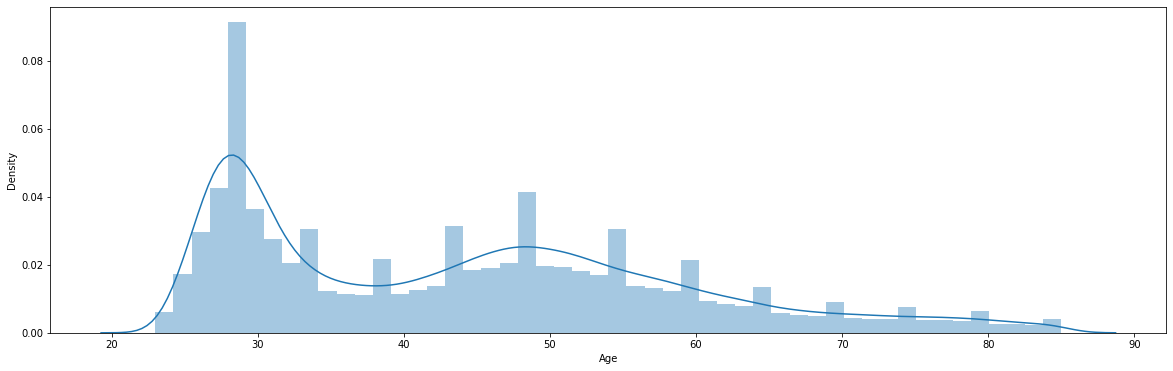

In [33]:
sns.distplot(train_data.Age)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


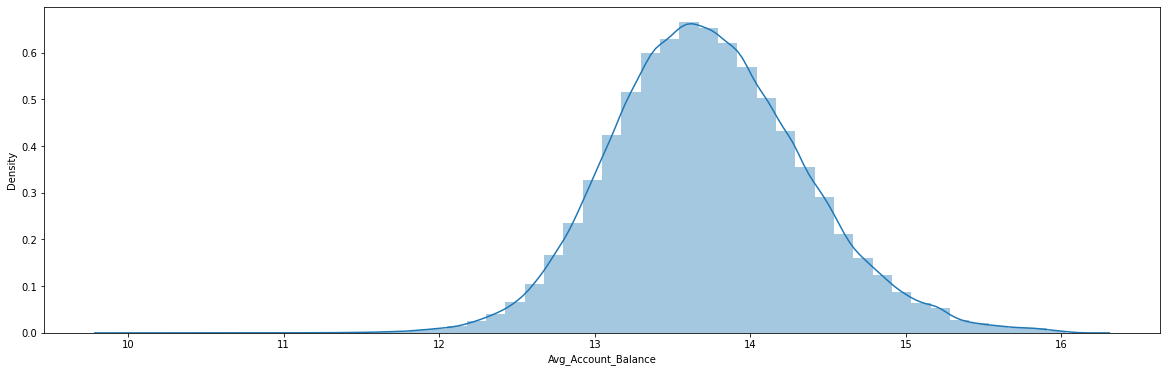

In [35]:
sns.distplot(np.log(train_data.Avg_Account_Balance))

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


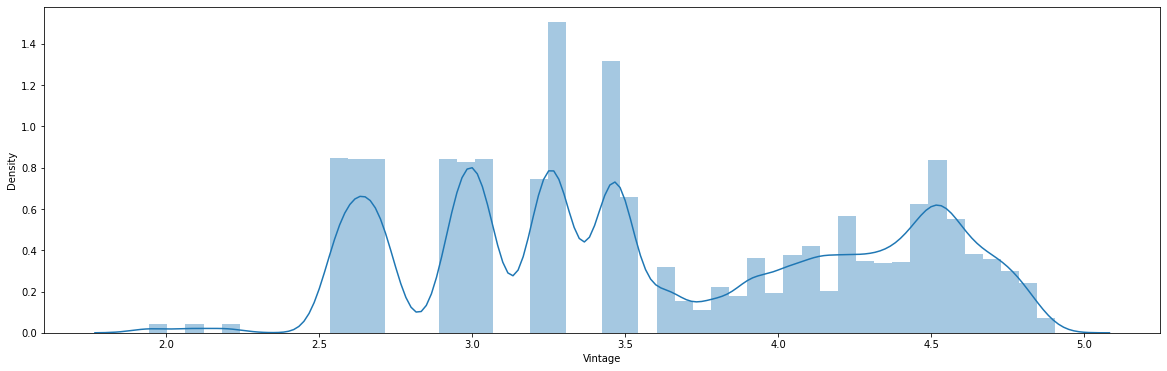

In [41]:
sns.distplot(np.log(train_data.Vintage))

### Univariate

Distributions, Outliers

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


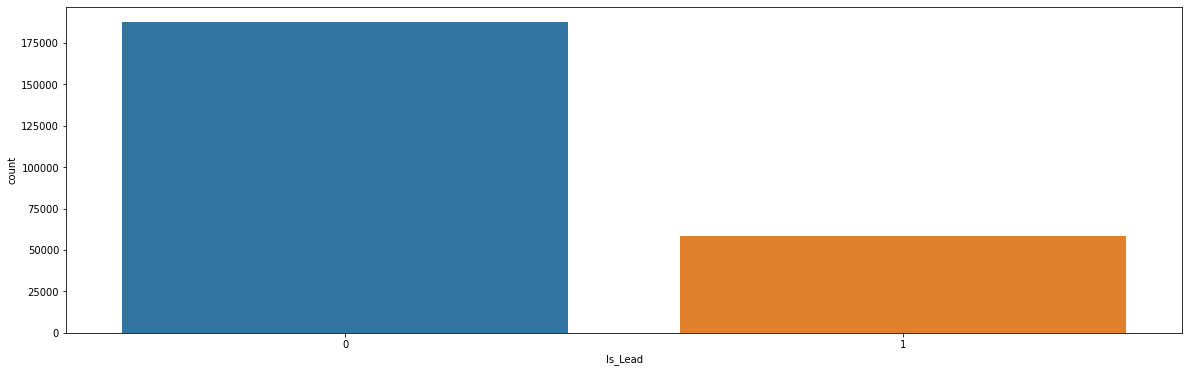

In [25]:
#plt.subplot(1,2,1)
sns.countplot(train_data.Is_Lead, order = train_data.Is_Lead.value_counts().index )
#plt.subplot(1,2,2)
#sns.countplot(sub_data.Is_Lead, order = [1,2,3,4])
plt.show()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


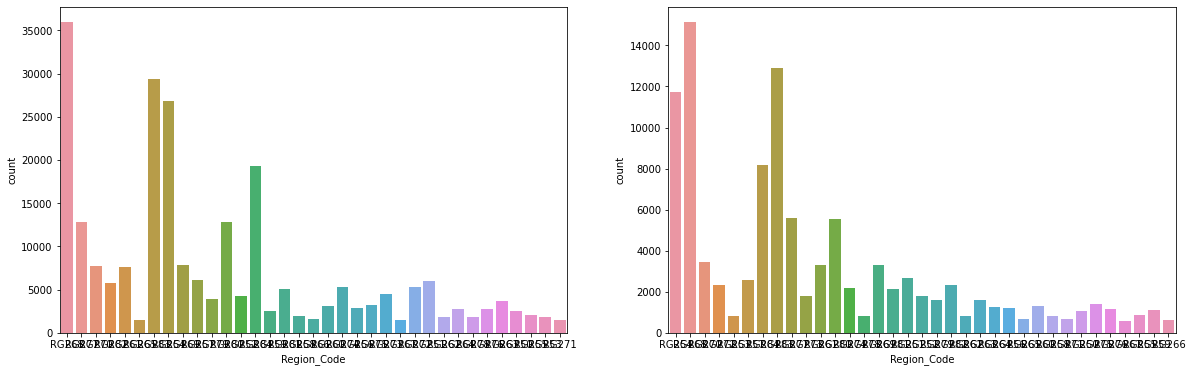

In [24]:
plt.subplot(1,2,1)
sns.countplot(train_data.Region_Code )
plt.subplot(1,2,2)
sns.countplot(sub_data.Region_Code)
plt.show()

### Bivariate

Comparision, corelation

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data.XXX, order = train_data.xxx.values_count().index )
plt.subplot(1,2,2)
sns.countplot(sub_data.XXX, order = [1,2,3,4])
plt.show()

### With sub_data

Submit pattern, cv on, splitted on

## Data Validation

Replace xxx with proper data  

1) Random split
2) Catogorical split
3) Time based split

In [6]:
X = train_data.drop(['Is_Lead'], axis = 1)
y = train_data["Is_Lead"]

cat_train, cat_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75, stratify = train_data["Is_Lead"], random_state = 42)

X = train_data.drop(['Is_Lead', 'Region_Code'], axis = 1)
X = pd.get_dummies(X) #, dummy_na = True
X_sub = sub_data.drop(["Region_Code"], axis = 1)
X_sub = pd.get_dummies(X_sub)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75, stratify = train_data["Is_Lead"], random_state = 42)

In [7]:
print("Train set rows %s, cols %s and y is %s" % (X_train.shape[0], X_train.shape[1], y_train.shape[0]))
print("Test set rows %s, cols %s and y is %s" % (X_test.shape[0], X_test.shape[1], y_test.shape[0]))
print("Submission set rows %s, cols %s and y is to be predicted" % (X_sub.shape[0], X_sub.shape[1]))

Train set rows 184293, cols 20 and y is 184293
Test set rows 61432, cols 20 and y is 61432
Submission set rows 105312, cols 20 and y is to be predicted


In [225]:
cat_train.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Is_Active,log_avg_ac_bal,VinByBal,perAgeBal,LogVinByBal,LogperAgeBal
194686,0,58,RG268,Self_Employed,X3,104,Yes,0,14.760818,24746.192308,44372.482759,0.141931,0.254497
118406,0,62,RG268,Other,X1,20,Yes,0,14.512880,100423.150000,32394.564516,0.725644,0.234079
148269,0,51,RG254,Other,X3,128,No,1,14.140844,10816.343750,27146.901961,0.110475,0.277271
11222,1,28,RG254,Other,X1,26,No,0,14.624520,86372.423077,80202.964286,0.562482,0.522304
44128,0,26,RG268,Salaried,X1,15,No,1,14.640057,152056.466667,87724.884615,0.976004,0.563079


In [226]:
X_train.head()

,Gender,Age,Vintage,Is_Active,log_avg_ac_bal,VinByBal,perAgeBal,LogVinByBal,LogperAgeBal,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_NA,Credit_Product_No,Credit_Product_Yes
194686,0,58,104,0,14.760818,24746.192308,44372.482759,0.141931,0.254497,0,0,0,1,0,0,1,0,0,0,1
118406,0,62,20,0,14.512880,100423.150000,32394.564516,0.725644,0.234079,0,1,0,0,1,0,0,0,0,0,1
148269,0,51,128,1,14.140844,10816.343750,27146.901961,0.110475,0.277271,0,1,0,0,0,0,1,0,0,1,0
11222,1,28,26,0,14.624520,86372.423077,80202.964286,0.562482,0.522304,0,1,0,0,1,0,0,0,0,1,0
44128,0,26,15,1,14.640057,152056.466667,87724.884615,0.976004,0.563079,0,0,1,0,1,0,0,0,0,1,0


In [ ]:
# # Run only if required

# for x in set(X_train.columns) - set(X_sub.columns) :
#     X_sub[x] = 0

# X_sub = X_sub[X.columns]
    
# print("Submission set rows %s, cols %s and y is to be predicted" % (X_sub.shape[0], X_sub.shape[1]))

### Mean Encoding
- shouldn't ME be only on train data. Average from Validation causes leakages.

In [220]:
cat_train.head()

,Gender,Age,Occupation,Channel_Code,Vintage,Credit_Product,Is_Active,log_avg_ac_bal,VinByBal,perAgeBal,LogVinByBal,LogperAgeBal
194686,0,58,Self_Employed,X3,104,Yes,0,14.760818,24746.192308,44372.482759,0.141931,0.254497
118406,0,62,Other,X1,20,Yes,0,14.512880,100423.150000,32394.564516,0.725644,0.234079
148269,0,51,Other,X3,128,No,1,14.140844,10816.343750,27146.901961,0.110475,0.277271
11222,1,28,Other,X1,26,No,0,14.624520,86372.423077,80202.964286,0.562482,0.522304
44128,0,26,Salaried,X1,15,No,1,14.640057,152056.466667,87724.884615,0.976004,0.563079


In [227]:
# Give a loop instead
def mean_enconde(trainset, testset, on_test, colname, target="Top-up Month"):
    ntrain = trainset.copy()
    ntest = testset.copy()
    for col in colname:
        # cat_train.assign(target = y_train).groupby(["Gender"])["target"].count()
        name_me = trainset.groupby(col)[target].mean()
        if on_test == False:
            ntrain[col] = ntrain[col].replace(name_me.index, name_me.values)
        else:
            ntest[col] = ntest[col].replace(name_me.index, name_me.values)
    return ntrain if on_test == False else ntest

In [228]:
X_train_me = mean_enconde(cat_train.assign(target = y_train), cat_test, on_test=False, colname = ["Region_Code"], target="target").drop(["target"], axis = 1)
X_test_me = mean_enconde(cat_train.assign(target = y_train), cat_test, on_test=True, colname = ["Region_Code"], target="target")

X_train_me = pd.get_dummies(X_train_me)
X_test_me = pd.get_dummies(X_test_me)

In [242]:
X_Sub_me = mean_enconde(cat_train.assign(target = y_train), sub_data, on_test=True, colname = ["Region_Code"], target="target")
X_Sub_me = pd.get_dummies(X_test_me)

Pending

In [ ]:
# X_sub_me = mean_enconde(X_sub.assign(target = y_train), cat_test, on_test=True, colname = ["Gender", "Region_Code", "Occupation", "Channel_Code", "Credit_Product", "Is_Active"], target="target")

In [229]:
print("Train set rows %s, cols %s and y is %s" % (X_train_me.shape[0], X_train_me.shape[1], y_train.shape[0]))
print("Test set rows %s, cols %s and y is %s" % (X_test_me.shape[0], X_test_me.shape[1], y_test.shape[0]))
# print("Submission set rows %s, cols %s and y is to be predicted" % (X_sub.shape[0], X_sub.shape[1]))

Train set rows 184293, cols 21 and y is 184293
Test set rows 61432, cols 21 and y is 61432


In [230]:
X_train_me.head()

,Gender,Age,Region_Code,Vintage,Is_Active,log_avg_ac_bal,VinByBal,perAgeBal,LogVinByBal,LogperAgeBal,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_NA,Credit_Product_No,Credit_Product_Yes
194686,0,58,0.300189,104,0,14.760818,24746.192308,44372.482759,0.141931,0.254497,0,0,0,1,0,0,1,0,0,0,1
118406,0,62,0.300189,20,0,14.512880,100423.150000,32394.564516,0.725644,0.234079,0,1,0,0,1,0,0,0,0,0,1
148269,0,51,0.211394,128,1,14.140844,10816.343750,27146.901961,0.110475,0.277271,0,1,0,0,0,0,1,0,0,1,0
11222,1,28,0.211394,26,0,14.624520,86372.423077,80202.964286,0.562482,0.522304,0,1,0,0,1,0,0,0,0,1,0
44128,0,26,0.300189,15,1,14.640057,152056.466667,87724.884615,0.976004,0.563079,0,0,1,0,1,0,0,0,0,1,0


In [231]:
X_test_me.head()

,Gender,Age,Region_Code,Vintage,Is_Active,log_avg_ac_bal,VinByBal,perAgeBal,LogVinByBal,LogperAgeBal,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_NA,Credit_Product_No,Credit_Product_Yes
89079,1,51,0.302269,92,1,14.748777,27639.141304,49858.843137,0.160313,0.289192,0,0,0,1,0,0,1,0,0,1,0
120964,1,60,0.235484,19,1,13.448577,36466.105263,11547.600000,0.707820,0.224143,0,0,0,1,0,1,0,0,0,0,1
219091,1,58,0.300189,104,1,13.442043,6618.682692,11867.982759,0.129250,0.231759,0,0,0,1,0,0,1,0,0,1,0
13972,0,51,0.300189,115,0,14.334913,14617.591304,32961.235294,0.124651,0.281077,0,0,0,1,0,0,1,0,0,1,0
212175,1,61,0.171101,33,0,13.439181,20799.272727,11252.065574,0.407248,0.220314,0,0,0,1,1,0,0,0,0,0,1


In [243]:
X_Sub_me.head()

,Gender,Age,Region_Code,Vintage,Is_Active,log_avg_ac_bal,VinByBal,perAgeBal,LogVinByBal,LogperAgeBal,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_NA,Credit_Product_No,Credit_Product_Yes
89079,1,51,0.302269,92,1,14.748777,27639.141304,49858.843137,0.160313,0.289192,0,0,0,1,0,0,1,0,0,1,0
120964,1,60,0.235484,19,1,13.448577,36466.105263,11547.600000,0.707820,0.224143,0,0,0,1,0,1,0,0,0,0,1
219091,1,58,0.300189,104,1,13.442043,6618.682692,11867.982759,0.129250,0.231759,0,0,0,1,0,0,1,0,0,1,0
13972,0,51,0.300189,115,0,14.334913,14617.591304,32961.235294,0.124651,0.281077,0,0,0,1,0,0,1,0,0,1,0
212175,1,61,0.171101,33,0,13.439181,20799.272727,11252.065574,0.407248,0.220314,0,0,0,1,1,0,0,0,0,0,1


### Validataion EDA

## Modeling

For Regression verify distribution.  
For Classification verify confusion matrix.  
Use 10 fold cross validation to verify final model.  

### Submission Part

Ensure that model is trained on whole set

In [ ]:
pd.concat([sub_data_og.ID, sub_data_og.ID], axis = 1)

In [9]:
weights = y.value_counts() / y.value_counts().sum()
pddf = pd.DataFrame({"A": sub_data_og.ID})

# 1400 rounds based on train_test_split

for i in range(10):
    rs = np.random.randint(1000)
    print(rs)
    xgb_model = xgb.XGBClassifier(learning_rate=0.01, scale_pos_weight = weights[0], n_estimators = 1350, subsample=.90)
    xgb_model.fit(X, y, eval_metric = "auc")
    prediction = pd.DataFrame({rs:xgb_model.predict(X_sub)})
    pddf = pd.concat([pddf, prediction], axis = 1)

418


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


889
430
95
903
684
292
729
345
907


In [10]:
pddf.head()

,A,418,889,430,95,903,684,292,729,345,907
0,VBENBARO,0,0,0,0,0,0,0,0,0,0
1,CCMEWNKY,1,1,1,1,1,1,1,1,1,1
2,VK3KGA9M,0,0,0,0,0,0,0,0,0,0
3,TT8RPZVC,0,0,0,0,0,0,0,0,0,0
4,SHQZEYTZ,0,0,0,0,0,0,0,0,0,0


In [15]:
pddf.mean(axis = 1).sum() / pddf.mean(axis = 1).count()

0.13947128532360983

In [17]:
pd.DataFrame({'ID': sub_data_og.ID, "Is_Lead": pddf.mean(axis = 1)}).to_csv("sub01.csv", index=False)

### XGBoost

Monitor metric performance on both train and test.  

In [232]:
X_train_me.head()

,Gender,Age,Region_Code,Vintage,Is_Active,log_avg_ac_bal,VinByBal,perAgeBal,LogVinByBal,LogperAgeBal,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_NA,Credit_Product_No,Credit_Product_Yes
194686,0,58,0.300189,104,0,14.760818,24746.192308,44372.482759,0.141931,0.254497,0,0,0,1,0,0,1,0,0,0,1
118406,0,62,0.300189,20,0,14.512880,100423.150000,32394.564516,0.725644,0.234079,0,1,0,0,1,0,0,0,0,0,1
148269,0,51,0.211394,128,1,14.140844,10816.343750,27146.901961,0.110475,0.277271,0,1,0,0,0,0,1,0,0,1,0
11222,1,28,0.211394,26,0,14.624520,86372.423077,80202.964286,0.562482,0.522304,0,1,0,0,1,0,0,0,0,1,0
44128,0,26,0.300189,15,1,14.640057,152056.466667,87724.884615,0.976004,0.563079,0,0,1,0,1,0,0,0,0,1,0


In [233]:
X_train.head()

,Gender,Age,Vintage,Is_Active,log_avg_ac_bal,VinByBal,perAgeBal,LogVinByBal,LogperAgeBal,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_NA,Credit_Product_No,Credit_Product_Yes
194686,0,58,104,0,14.760818,24746.192308,44372.482759,0.141931,0.254497,0,0,0,1,0,0,1,0,0,0,1
118406,0,62,20,0,14.512880,100423.150000,32394.564516,0.725644,0.234079,0,1,0,0,1,0,0,0,0,0,1
148269,0,51,128,1,14.140844,10816.343750,27146.901961,0.110475,0.277271,0,1,0,0,0,0,1,0,0,1,0
11222,1,28,26,0,14.624520,86372.423077,80202.964286,0.562482,0.522304,0,1,0,0,1,0,0,0,0,1,0
44128,0,26,15,1,14.640057,152056.466667,87724.884615,0.976004,0.563079,0,0,1,0,1,0,0,0,0,1,0


In [234]:
weights = y_train.value_counts() / y_train.value_counts().sum()

In [235]:
# xgb.XGBRegressor or xgb.XGBClassifier
xgb_model = xgb.XGBClassifier(learning_rate=0.01, scale_pos_weight = weights[0], n_estimators = 100000)
xgb_model.fit(X_train_me, y_train, eval_metric = "auc", eval_set = [(X_train_me, y_train), (X_test_me, y_test)], verbose = 1000, early_stopping_rounds=50)

#joblib.dump(xgb_model, "drive/My Drive/PyColab Work/xxx/xgb_model.sav")
#confusion_matrix(y_train, xgb_model.predict(X_train))

[0]	validation_0-auc:0.84774	validation_1-auc:0.844262
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1000]	validation_0-auc:0.874331	validation_1-auc:0.871431
Stopping. Best iteration:
[1377]	validation_0-auc:0.875342	validation_1-auc:0.871623



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.7627907733880288,
              seed=None, silent=None, subsample=1, verbosity=1)

In [236]:
#classification_report()
confusion_matrix(y_train, xgb_model.predict(X_train_me))

array([[136926,   3651],
       [ 22299,  21417]])

In [ ]:
#classification_report()
# confusion_matrix(y_test, xgb_model.predict(X_test_me))

In [ ]:
# groups = X_train[["Transmission", "Fuel_Type_CNG", "Fuel_Type_Diesel", "Fuel_Type_Electric", "Fuel_Type_LPG", "Fuel_Type_Petrol"]]
### DATA LEAKAGE
# cvscores = cross_val_score(xgb_model, X_train_me, y_train, cv = 5, scoring="roc_auc", n_jobs=4) # Add Fuel Type as well

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


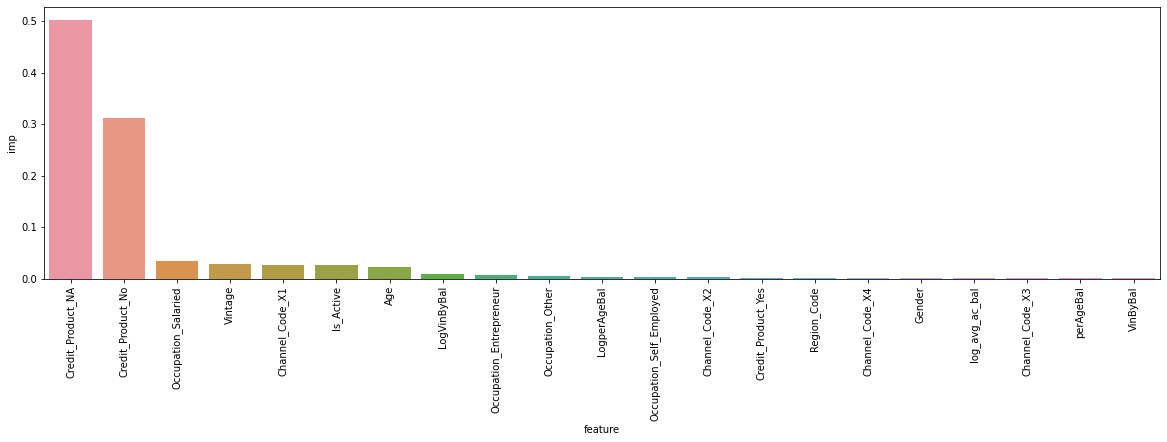

In [237]:
plt.figure(figsize = (20, 5))
sns.barplot("feature", "imp", data = pd.DataFrame( {'feature' : X_train_me.columns, 'imp' : xgb_model.feature_importances_ }).sort_values("imp", ascending = False) )
plt.xticks(rotation = 90)
plt.show()

In [239]:
#classification_report()
confusion_matrix(y_test, xgb_model.predict(X_test_me))

array([[45582,  1278],
       [ 7414,  7158]])

In [195]:
#classification_report()
confusion_matrix(y_test, xgb_model.predict(X_test))

array([[45585,  1275],
       [ 7383,  7189]])

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(xgb_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[0:nsize,:])
b = shap.summary_plot(shap_values, X_test.iloc[0:nsize,:])

#### Hyperparameter Tuning

Draw appropriate graph to understand impact of two hyperparameters.  
eg: rounds to maxdepth can give an idea where it overfits.

##### GridSearchCV

In [ ]:
cv= RepeatedKFold(2, 2)
xgb_engine = xgb.XGBRegressor() #n_estimator not used
xgb_params = {'booster' : ['gbtree'],
              'max_depth' : [3, 4], 
              'gamma' : [0], 
              'learning_rate' : [0.3], 
              "n_estimators" : [100000], 
              'min_child_weight' : [5, 10], 
              'subsample' : [1], 
              'colsample_bytree' : [0.7, 1], 
              'colsample_bylevel' : [1], 
              'colsample_bynode' : [1], 
              'reg_lambda' : [0, 1], 
              'reg_alpha' : [0, 1]}

xgb_grid = GridSearchCV(xgb_engine, xgb_params, cv = cv, n_jobs = 4, verbose = 0, return_train_score  = True)
xgb_grid.fit(X_train, y_train, eval_set = [(X_train, y_train)], early_stopping_rounds=10, verbose = 1000)

#joblib.dump(xgb_grid, "F:/Vasim/Python Stuff/Flight/gridxgboost.sav")

#print( np.sqrt( -cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv = cv, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, xgb_grid.predict(X_test)) ) )

##### Skopt

In [ ]:
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

# set up hyperparameter space
space = [Integer(3, 50, name='max_depth'),
         Integer(8, 200, name='n_estimators'),
         Integer(3, 50, name='min_child_weight'),
         Real(0.001, 1.0, name='learning_rate')]

regressor = xgb.XGBRegressor()

from sklearn.model_selection import cross_val_score

@use_named_args(space)
def objective(**params):
    regressor.set_params(**params)
    return -np.mean(cross_val_score(regressor, X_train, y_train, cv=5, n_jobs=1, scoring='neg_mean_squared_error'))

In [ ]:
reg_gp = gp_minimize(objective, space, verbose=False)

print('best score: {}'.format(reg_gp.fun))

print('best params:')
print('        max_depth: {}'.format(reg_gp.x[0]))
print('     n_estimators: {}'.format(reg_gp.x[1]))
print(' min_child_weight: {}'.format(reg_gp.x[2]))
print('    learning_rate: {}'.format(reg_gp.x[3]))

In [ ]:
import skopt.plots
skopt.plots.plot_convergence(reg_gp)

In [ ]:
skopt.plots.plot_evaluations(reg_gp, bins = 20)
plt.show()

In [ ]:
skopt.plots.plot_objective(reg_gp)
plt.show()

##### Hyperopt

### LightGBM
Inbuilt Categorical features

In [ ]:
lgbm_model = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=100000)
lgbm_model.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose = 1000)

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(lgbm_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

#### Hyperparamter Tuning

In [ ]:
lgbm_engine = lgb.LGBMRegressor()
lgbm_params = {'max_depth' : [17], 'learning_rate' : [0.05], 'n_estimators': [100000],  'min_child_samples' : [3], 'num_leaves' : [40], 'min_child_weight' : [0.001], 
               'min_split_gain' : [0], 'colsample_bytree' : [0.3], 'reg_alpha' : [0], 'reg_lamba' : [0], 'importance_type' : ['split'] }

lgbm_grid = GridSearchCV(lgbm_engine, lgbm_params, cv = 4, n_jobs = 4, verbose = 0)
lgbm_grid.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose = 1000)
#print( np.sqrt( -cross_val_score(lgbm_grid.best_estimator_, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, lgbm_grid.predict(X_test)) ) )

### CatBoost

Inbuilt Categorical features  

The cat.cv - inbuilt cross validation gives cross validated result on each iterations.   
The only hyperparameter we can select from in built cv is no of iteration.  
Try sklearn cv type with for loop for cv score or skopt or hyperopt module.  

In [ ]:
from catboost import CatBoostRegressor, Pool
categorical_features_indices = np.where(cat_train.dtypes == 'object')[0]

cat_model = CatBoostRegressor(iterations = 100000, learning_rate = 0.01)
cat_model.fit(cat_train, y_train, eval_set = (cat_test, y_test), cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=100)

#print( np.sqrt( -cross_val_score(cat_model, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error", verbose = False) ) )
#np.sqrt(mean_squared_error(y_test, cat_model.predict(X_test)))

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(cat_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

#### Hyperparamter Tuning

In [ ]:
cat_engine = CatBoostRegressor()
cat_params = {'max_depth' : [4], 'learning_rate' : [0.1], 'iterations': [100000], 'colsample_bylevel' : [1]}
    
cat_grid = GridSearchCV(cat_engine, cat_params, cv = 4, n_jobs = 4, verbose = False)
cat_grid.fit(cat_train, y_train, eval_set = (cat_val, y_val), cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=100)

### SVM

Apply scaling

In [ ]:
#%%script false

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Scaling only on numeric data.
svmpipe = Pipeline([ ( "std", StandardScaler() ), ("mimax", MinMaxScaler()) , ( "svm", SVR(gamma = 'scale', kernel = 'rbf', C = 1.5, epsilon = 0.1, max_iter=-1) ) ])
svmpipe.fit(X_train, y_train)

#np.sqrt( -cross_val_score(svmpipe, X_train.astype(float), y_train.astype(float), cv = 5, scoring = "neg_mean_squared_error") )
np.sqrt( mean_squared_error(y_test, svmpipe.predict(X_test))) 

#### SHAP

#### Hyperparamter Tuning

### KNN

Apply scaling

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

#Scaling on numeric data only
neigh = KNeighborsRegressor(n_neighbors=5)
knnpipe = Pipeline([ ( "std", StandardScaler() ), ("minmax", MinMaxScaler() ), ( "knn", neigh ) ])

#scale data
knnpipe.fit(X_train, y_train) 
print( np.sqrt( -cross_val_score(neigh, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
#np.sqrt(mean_squared_error(y_test, neigh.predict(X_test)))

#### SHAP

#### Hyperparamter Tuning

### Keras

Apply scaling

In [ ]:
#!pip install tensorboardcolab
# Apply scaling

from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout
#tbc=TensorBoardColab()

model2 = Sequential()
model2.add(Dense(200, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model2.add(Dense(30, kernel_initializer='normal', activation='relu'))
model2.add(Dropout(.10))
#model.add(Dense(10, kernel_initializer='normal', activation='relu'))
#model.add(Dropout(.10))
model2.add(Dense(1, kernel_initializer='normal'))

model2.compile(loss='mean_squared_error', optimizer='adam')

model2.fit(X_train, y_train, epochs = 18, verbose = 0) #callbacks=[TensorBoardColabCallback(tbc)]
pd.DataFrame( {"Actual" : np.exp(y_test), "Predict" : np.exp(model2.predict(X_test)[0:,0])} ).describe()

#### SHAP

#### Hyperparamter Tuning

### Linear

inludes - Logistic  
Panelty - Ridge, Lasso and ElasticNet  


#### SHAP

#### Hyperparamter Tuning

## Stacking

In [ ]:
#mlextend